# Аналитическая база данных по промышленной безопасности

<b>Цель.</b> ...:
 * ...

# Краткое описание проекта

В ходе выполнения проекта:
</br>1. Провёл анализ датасета: проанализировал объём данных и его качество, выявил и обработал ошибки в данных.
</br>...

# Выполнение проекта

1. Импортируем основные библиотеки.

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Mapping
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import SMOTE
# from lightgbm import LGBMClassifier

2. Считываем данные из CSV-файла. Выводим первые 5 строк, чтобы убедиться, что данные считались с локального файла.

In [11]:
df = pd.read_csv('database_with_accidents_description.csv')
pd.set_option('display.max_columns', None)
df.head(10)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
5,5,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...
6,6,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...
7,7,2016-01-17 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic..."
8,8,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...
9,9,2016-01-26 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...


Целевая переменная - <b>Accident Level</b>.

Приведём описание признаков:
Data: timestamp or time/date information
Countries: which country the accident occurred (anonymized)
Local: the city where the manufacturing plant is located (anonymized)
Industry sector: which sector the plant belongs to
Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
Genre: if the person is male of female
Employee or Third Party: if the injured person is an employee or a third party
Critical Risk: some description of the risk involved in the accident
Description: Detailed description of how the accident happened.

Для удобства заменим заголовки в датасете.

3. Посмотрим на количество записей в файле.

In [3]:
df.shape

(425, 11)

4. Посмотрим, какого типа эти данные:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.7+ KB


Видим, что пропущенные значения отсутствуют. Есть категориальные признаки.

In [5]:
# Просмотр количества уникальных записей для каждого признака
df.apply(lambda x: x.nunique())

Unnamed: 0                  425
Data                        287
Countries                     3
Local                        12
Industry Sector               3
Accident Level                5
Potential Accident Level      6
Genre                         2
Employee or Third Party       3
Critical Risk                33
Description                 411
dtype: int64

# EDA

1. Выберем целевую переменную.

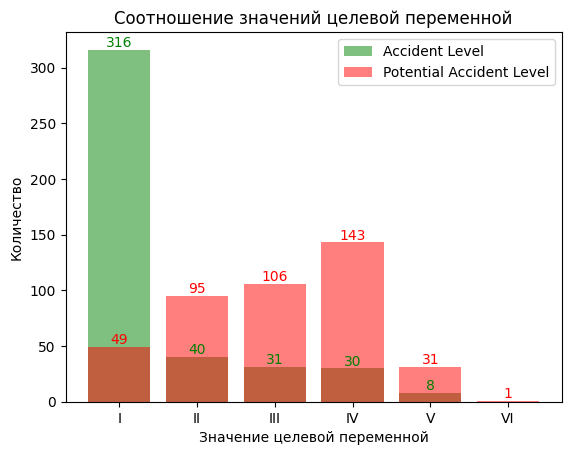

In [6]:
fig, ax = plt.subplots()

# Данные для первого графика
accident_level_counts = df['Accident Level'].value_counts().sort_index()
# Данные для второго графика
potential_accident_level_counts = df['Potential Accident Level'].value_counts().sort_index()

# Первый график (Зелёный прозрачный)
ax.bar(accident_level_counts.index, accident_level_counts, color='green', alpha=0.5, label='Accident Level')

# Второй график (Красный прозрачный)
ax.bar(potential_accident_level_counts.index, potential_accident_level_counts, color='red', alpha=0.5, label='Potential Accident Level')

plt.title('Соотношение значений целевой переменной')
plt.xlabel('Значение целевой переменной')
plt.ylabel('Количество')

# Подписи для первого графика
for i, value in enumerate(accident_level_counts):
    plt.text(i, value, str(value), ha='center', va='bottom', color='green')

# Подписи для второго графика
for i, value in enumerate(potential_accident_level_counts):
    plt.text(i, value, str(value), ha='center', va='bottom', color='red')

# Отображение легенды
plt.legend()

plt.show()

In [12]:
# Преобразование столбца Data в тип datetime
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d %H:%M:%S')

# Извлечение названия месяца
df['Month'] = df['Data'].dt.strftime('%B')

In [13]:
columns_to_drop = ["Unnamed: 0", "Data", "Countries", "Local", "Industry Sector", "Accident Level",]
df = df.drop(columns=columns_to_drop)
df.head(10)

,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Month
0,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,January
1,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,January
2,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,January
3,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,January
4,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,January
5,III,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...,January
6,III,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...,January
7,III,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic...",January
8,IV,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...,January
9,II,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...,January


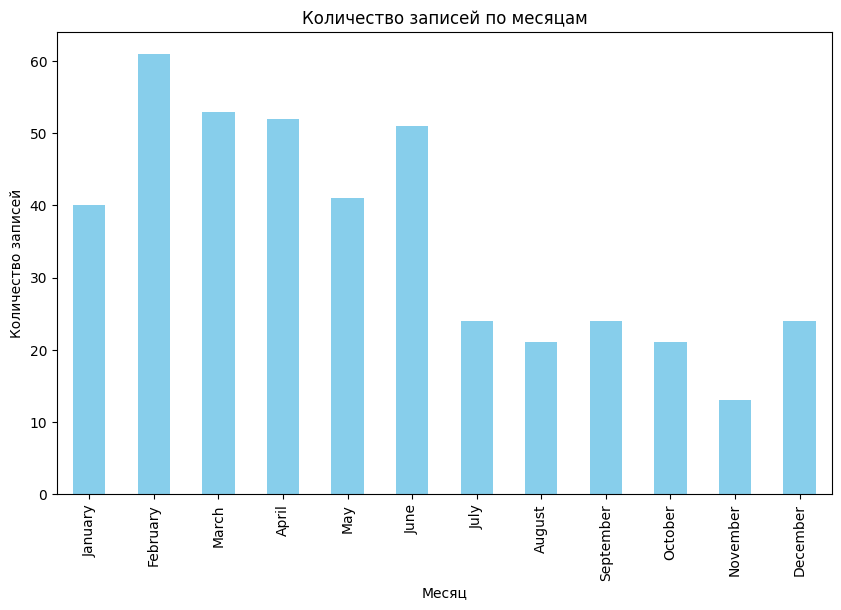

In [14]:
# Создаем словарь с порядком сортировки месяцев
month_order = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Выполняем подсчет и сортировку
month_counts = df['Month'].value_counts().sort_index(
    key=lambda x: x.map(month_order)
)

# Создание графика
plt.figure(figsize=(10, 6))  # Размер графика

# Построение столбчатой диаграммы
month_counts.plot(kind='bar', color='skyblue')

# Настройка заголовка и меток осей
plt.title('Количество записей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество записей')

# Отображение графика
plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Создаем объект LabelEncoder
label_encoder = LabelEncoder()

# Применяем LabelEncoder к столбцу 'Potential Accident Level'
df['Potential Accident Level Encoded'] = label_encoder.fit_transform(df['Potential Accident Level']) + 1

# Маппинг значений после кодирования
level_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_) + 1))
print("Mapping for Potential Accident Level:")
print(level_mapping)

Mapping for Potential Accident Level:
{'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6}


In [16]:
df.head(10)

,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Month,Potential Accident Level Encoded
0,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,January,4
1,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,January,4
2,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,January,3
3,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,January,1
4,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,January,4
5,III,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...,January,3
6,III,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...,January,3
7,III,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic...",January,3
8,IV,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...,January,4
9,II,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...,January,2


In [17]:
# Применяем One-Hot Encoding с помощью pd.get_dummies
df_encoded = pd.get_dummies(df, columns=['Genre', 'Employee or Third Party', 'Critical Risk', 'Month'])

In [18]:
# Выводим результаты
print("DataFrame after One-Hot Encoding:")
df_encoded.head(10)

DataFrame after One-Hot Encoding:


,Potential Accident Level,Description,Potential Accident Level Encoded,Genre_Female,Genre_Male,Employee or Third Party_Employee,Employee or Third Party_Third Party,Employee or Third Party_Third Party (Remote),Critical Risk_\nNot applicable,Critical Risk_Bees,Critical Risk_Blocking and isolation of energies,Critical Risk_Burn,Critical Risk_Chemical substances,Critical Risk_Confined space,Critical Risk_Cut,Critical Risk_Electrical Shock,Critical Risk_Electrical installation,Critical Risk_Fall,Critical Risk_Fall prevention,Critical Risk_Fall prevention (same level),Critical Risk_Individual protection equipment,Critical Risk_Liquid Metal,Critical Risk_Machine Protection,Critical Risk_Manual Tools,Critical Risk_Others,Critical Risk_Plates,Critical Risk_Poll,Critical Risk_Power lock,Critical Risk_Pressed,Critical Risk_Pressurized Systems,Critical Risk_Pressurized Systems / Chemical Substances,Critical Risk_Projection,Critical Risk_Projection of fragments,Critical Risk_Projection/Burning,Critical Risk_Projection/Choco,Critical Risk_Projection/Manual Tools,Critical Risk_Suspended Loads,Critical Risk_Traffic,Critical Risk_Vehicles and Mobile Equipment,Critical Risk_Venomous Animals,Critical Risk_remains of choco,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,IV,While removing the drill rod of the Jumbo 08 f...,4,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,IV,During the activation of a sodium sulphide pum...,4,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,III,In the sub-station MILPO located at level +170...,3,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,I,Being 9:45 am. approximately in the Nv. 1880 C...,1,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,IV,Approximately at 11:45 a.m. in circumstances t...,4,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
5,III,During the unloading operation of the ustulado...,3,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
6,III,The collaborator reports that he was on street...,3,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
7,III,"At approximately 04:50 p.m., when the mechanic...",3,False,True,False,True,False,False,False,False,False,False,False,False,False,False,Fals

In [23]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
import string

# Загружаем модель spaCy для NER и лемматизации
nlp = spacy.load('en_core_web_sm')

# Функция для очистки текста
def clean_description(text):
    doc = nlp(text)
    names = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    clean_text = text
    for name in names:
        clean_text = re.sub(r'\b' + re.escape(name) + r'\b', '', clean_text)
    
    # Преобразование текста в нижний регистр
    clean_text = clean_text.lower()
    
    # Удаление стоп-слов
    clean_text = ' '.join([word for word in clean_text.split() if word not in STOP_WORDS])
    
    # Удаление коротких слов
    clean_text = ' '.join([word for word in clean_text.split() if len(word) > 2])
    
    # Удаление чисел
    clean_text = re.sub(r'\b\d+\b', '', clean_text)
    
    # Удаление пунктуации
    clean_text = clean_text.translate(str.maketrans('', '', string.punctuation))
    
    return clean_text, names

# Функция для лемматизации текста
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc])
    return lemmatized_text

# Функция для удаления лишних пробелов
def remove_extra_spaces(text):
    return ' '.join(text.split())

# # Загружаем датасет
# df = pd.read_csv('path_to_your_dataset.csv')

# Применяем функцию ко всему столбцу Description и сохраняем удаленные имена
df_encoded['Cleaned_Description'], df_encoded['Removed_Names'] = zip(*df_encoded['Description'].apply(clean_description))

# Применяем лемматизацию к столбцу с очищенным описанием
df_encoded['Cleaned_Description'] = df_encoded['Cleaned_Description'].apply(lemmatize_text)

# Удаляем лишние пробелы
df_encoded['Cleaned_Description'] = df_encoded['Cleaned_Description'].apply(remove_extra_spaces)

# Выводим имена, которые были удалены
for idx, names in enumerate(df_encoded['Removed_Names']):
    if names:
        print(f"Row {idx}: Removed names - {names}")

# # Сохраняем очищенный и нормализованный датасет
# df.to_csv('cleaned_dataset.csv', index=False)

Row 3: Removed names - ['Cristóbal']
Row 4: Removed names - ['Anthony', 'Eduardo', 'Eric Fernández-injured']
Row 5: Removed names - ['Bag']
Row 7: Removed names - ['José', 'Miguel of the EKA Mining']
Row 14: Removed names - ['Waelz']
Row 16: Removed names - ['Jhonatan', 'Nilton']
Row 19: Removed names - ['Manuel', 'Manco', 'José']
Row 20: Removed names - ['Samuel']
Row 21: Removed names - ['Raise']
Row 24: Removed names - ['Mollares', 'Mollares']
Row 32: Removed names - ['Yaranga', 'Juan']
Row 33: Removed names - ['Albertico', 'Jhony', 'Launcher', 'Danon', 'Danon']
Row 47: Removed names - ['bin', 'bin']
Row 48: Removed names - ['Paid']
Row 55: Removed names - ['hose']
Row 56: Removed names - ['Kg']
Row 61: Removed names - ['William de la Cruz', 'Kg', 'William de']
Row 68: Removed names - ['La Laquia']
Row 69: Removed names - ['Simultaneously Jose']
Row 71: Removed names - ['Roy Canario']
Row 75: Removed names - ['Dumper']
Row 78: Removed names - ['Manetometer']
Row 79: Removed names - 

In [31]:
df_encoded.head()

,Potential Accident Level Encoded,Genre_Female,Genre_Male,Employee or Third Party_Employee,Employee or Third Party_Third Party,Employee or Third Party_Third Party (Remote),Critical Risk_\nNot applicable,Critical Risk_Bees,Critical Risk_Blocking and isolation of energies,Critical Risk_Burn,Critical Risk_Chemical substances,Critical Risk_Confined space,Critical Risk_Cut,Critical Risk_Electrical Shock,Critical Risk_Electrical installation,Critical Risk_Fall,Critical Risk_Fall prevention,Critical Risk_Fall prevention (same level),Critical Risk_Individual protection equipment,Critical Risk_Liquid Metal,Critical Risk_Machine Protection,Critical Risk_Manual Tools,Critical Risk_Others,Critical Risk_Plates,Critical Risk_Poll,Critical Risk_Power lock,Critical Risk_Pressed,Critical Risk_Pressurized Systems,Critical Risk_Pressurized Systems / Chemical Substances,Critical Risk_Projection,Critical Risk_Projection of fragments,Critical Risk_Projection/Burning,Critical Risk_Projection/Choco,Critical Risk_Projection/Manual Tools,Critical Risk_Suspended Loads,Critical Risk_Traffic,Critical Risk_Vehicles and Mobile Equipment,Critical Risk_Venomous Animals,Critical Risk_remains of choco,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Cleaned_Description
0,4,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,remove drill rod jumbo maintenance supervisor ...
1,4,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,activation sodium sulphide pump pipe uncoupled...
2,3,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,substation milpo locate level collaborator exc...
3,1,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,be approximately nv cx ob7 personnel begin tas...
4,4,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,approximately be circumstance mechanic group l...


In [29]:
columns_to_drop = ["Removed_Names", "Description", "Potential Accident Level",]
df_encoded = df_encoded.drop(columns=columns_to_drop)
df_encoded.head()

,Potential Accident Level Encoded,Genre_Female,Genre_Male,Employee or Third Party_Employee,Employee or Third Party_Third Party,Employee or Third Party_Third Party (Remote),Critical Risk_\nNot applicable,Critical Risk_Bees,Critical Risk_Blocking and isolation of energies,Critical Risk_Burn,Critical Risk_Chemical substances,Critical Risk_Confined space,Critical Risk_Cut,Critical Risk_Electrical Shock,Critical Risk_Electrical installation,Critical Risk_Fall,Critical Risk_Fall prevention,Critical Risk_Fall prevention (same level),Critical Risk_Individual protection equipment,Critical Risk_Liquid Metal,Critical Risk_Machine Protection,Critical Risk_Manual Tools,Critical Risk_Others,Critical Risk_Plates,Critical Risk_Poll,Critical Risk_Power lock,Critical Risk_Pressed,Critical Risk_Pressurized Systems,Critical Risk_Pressurized Systems / Chemical Substances,Critical Risk_Projection,Critical Risk_Projection of fragments,Critical Risk_Projection/Burning,Critical Risk_Projection/Choco,Critical Risk_Projection/Manual Tools,Critical Risk_Suspended Loads,Critical Risk_Traffic,Critical Risk_Vehicles and Mobile Equipment,Critical Risk_Venomous Animals,Critical Risk_remains of choco,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Cleaned_Description
0,4,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,remove drill rod jumbo maintenance supervisor ...
1,4,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,activation sodium sulphide pump pipe uncoupled...
2,3,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,substation milpo locate level collaborator exc...
3,1,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,be approximately nv cx ob7 personnel begin tas...
4,4,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,approximately be circumstance mechanic group l...


In [1]:
# Сохраняем очищенный и нормализованный датасет
df_encoded.to_csv('cleaned_dataset.csv', index=False)

NameError: name 'df_encoded' is not defined

In [5]:
df = pd.read_csv('cleaned_dataset.csv')

In [6]:
df.head()

,Potential Accident Level Encoded,Genre_Female,Genre_Male,Employee or Third Party_Employee,Employee or Third Party_Third Party,Employee or Third Party_Third Party (Remote),Critical Risk_\nNot applicable,Critical Risk_Bees,Critical Risk_Blocking and isolation of energies,Critical Risk_Burn,...,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Cleaned_Description
0,4,False,True,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,remove drill rod jumbo maintenance supervisor ...
1,4,False,True,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,activation sodium sulphide pump pipe uncoupled...
2,3,False,True,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,substation milpo locate level collaborator exc...
3,1,False,True,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,be approximately nv cx ob7 personnel begin tas...
4,4,False,True,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,approximately be circumstance mechanic group l...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 52 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Potential Accident Level Encoded                         425 non-null    int64 
 1   Genre_Female                                             425 non-null    bool  
 2   Genre_Male                                               425 non-null    bool  
 3   Employee or Third Party_Employee                         425 non-null    bool  
 4   Employee or Third Party_Third Party                      425 non-null    bool  
 5   Employee or Third Party_Third Party (Remote)             425 non-null    bool  
 6   Critical Risk_
Not applicable                            425 non-null    bool  
 7   Critical Risk_Bees                                       425 non-null    bool  
 8   Critical Risk_Blocking and isolation of 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Векторизация текста с использованием TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(df['Cleaned_Description'])

# Преобразование в DataFrame для объединения с исходным датасетом
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [9]:
# Объединение признаков
df_combined = pd.concat([df.drop(columns=['Cleaned_Description']), X_tfidf_df], axis=1)

In [10]:
df_combined.head()

,Potential Accident Level Encoded,Genre_Female,Genre_Male,Employee or Third Party_Employee,Employee or Third Party_Third Party,Employee or Third Party_Third Party (Remote),Critical Risk_\nNot applicable,Critical Risk_Bees,Critical Risk_Blocking and isolation of energies,Critical Risk_Burn,...,ydrs,yield,yolk,young,z014,zaf,zamac,zero,zinc,zone
0,4,False,True,False,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,4,False,True,True,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,False,True,False,False,True,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,1,False,True,False,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,4,False,True,False,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.224027,0.0,0.0,0.0,0.0


In [11]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Columns: 2461 entries, Potential Accident Level Encoded to zone
dtypes: bool(50), float64(2410), int64(1)
memory usage: 7.8 MB


In [12]:
df_combined = df_combined[df_combined['Potential Accident Level Encoded'] != 6]
df_combined.shape

(424, 2461)

In [47]:
# from sklearn.model_selection import train_test_split

# # Выделяем признаки и метки
# X = df_combined.drop(columns=['Potential Accident Level Encoded'])
# y = df_combined['Potential Accident Level Encoded']

# # Разбиение на тренировочную и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Выделяем признаки и метки
X = df_combined.drop(columns=['Potential Accident Level Encoded'])
y = df_combined['Potential Accident Level Encoded']

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [13]:
# Определение гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

# Настройка GridSearchCV
gb_clf = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Оценка модели с лучшими параметрами
best_gb_clf = grid_search.best_estimator_
y_pred_gb = best_gb_clf.predict(X_test)

# Оценка модели Gradient Boosting
gb_report = classification_report(y_test, y_pred_gb)
print("Gradient Boosting Classification Report:")
print(gb_report)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.40      0.53        10
           2       0.29      0.21      0.24        19
           3       0.33      0.19      0.24        21
           4       0.44      0.83      0.58        29
           5       0.00      0.00      0.00         6

    accuracy                           0.42        85
   macro avg       0.37      0.33      0.32        85
weighted avg       0.39      0.42      0.37        85



C:\Users\AADementev\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AADementev\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AADementev\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch 1/50, Train Loss: 1.7090, Test Loss: 1.6037
Epoch 2/50, Train Loss: 1.2174, Test Loss: 1.5751
Epoch 3/50, Train Loss: 0.8794, Test Loss: 1.5245
Epoch 4/50, Train Loss: 0.6258, Test Loss: 1.4600
Epoch 5/50, Train Loss: 0.4335, Test Loss: 1.3999
Epoch 6/50, Train Loss: 0.2837, Test Loss: 1.3637
Epoch 7/50, Train Loss: 0.1568, Test Loss: 1.4212
Epoch 8/50, Train Loss: 0.1285, Test Loss: 1.5319
Epoch 9/50, Train Loss: 0.0912, Test Loss: 1.6435
Epoch 10/50, Train Loss: 0.0765, Test Loss: 1.7048
Epoch 11/50, Train Loss: 0.0640, Test Loss: 1.7605
Epoch 12/50, Train Loss: 0.0509, Test Loss: 1.7686
Epoch 13/50, Train Loss: 0.0323, Test Loss: 1.7937
Epoch 14/50, Train Loss: 0.0375, Test Loss: 1.7939
Epoch 15/50, Train Loss: 0.0200, Test Loss: 1.8525
Epoch 16/50, Train Loss: 0.0443, Test Loss: 1.9260
Early stopping triggered
Neural Network Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.70      0.82        10
           2       0.

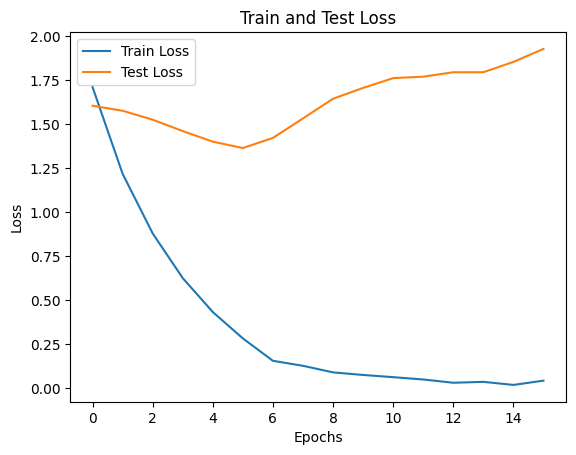

In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

# Преобразование всех столбцов в числовой формат
def convert_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        elif df[col].dtype == 'object':
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                df[col] = pd.factorize(df[col])[0]
    return df

# Выделяем признаки и метки
X = df_combined.drop(columns=['Potential Accident Level Encoded'])
y = df_combined['Potential Accident Level Encoded']

# Преобразование всех данных в числовой формат
X = convert_to_numeric(X)

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование меток классов в диапазон от 0 до num_classes-1
y_train = y_train - 1
y_test = y_test - 1

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader для PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели нейронной сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
hidden_size = 256  # Увеличение скрытого слоя
num_classes = len(y.unique())

model = MLP(input_size, hidden_size, num_classes)

# Определение функции потерь и оптимизатора с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Обучение модели с ранним прекращением
num_epochs = 50
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 10  # Число эпох без улучшений перед остановкой
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Проверка на тестовом наборе
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Раннее прекращение
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

# Оценка модели
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend((predicted + 1).numpy())  # Сдвиг предсказанных значений на +1
        y_true.extend((y_batch + 1).numpy())    # Сдвиг истинных значений на +1 для правильного сравнения

# Отчет о классификации
report = classification_report(y_true, y_pred)
print("Neural Network Classification Report:")
print(report)

# Проверка на переобучение и недообучение
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

Epoch 1/50, Train Loss: 1.6391, Test Loss: 1.5689
Epoch 2/50, Train Loss: 1.5887, Test Loss: 1.5457
Epoch 3/50, Train Loss: 1.5058, Test Loss: 1.5334
Epoch 4/50, Train Loss: 1.3976, Test Loss: 1.5266
Epoch 5/50, Train Loss: 1.3384, Test Loss: 1.5050
Epoch 6/50, Train Loss: 1.2861, Test Loss: 1.4726
Epoch 7/50, Train Loss: 1.1938, Test Loss: 1.4361
Epoch 8/50, Train Loss: 1.1337, Test Loss: 1.4141
Epoch 9/50, Train Loss: 1.1124, Test Loss: 1.3929
Epoch 10/50, Train Loss: 1.0451, Test Loss: 1.3770
Epoch 11/50, Train Loss: 1.0156, Test Loss: 1.3618
Epoch 12/50, Train Loss: 0.9236, Test Loss: 1.3505
Epoch 13/50, Train Loss: 0.8981, Test Loss: 1.3367
Epoch 14/50, Train Loss: 0.8070, Test Loss: 1.3296
Epoch 15/50, Train Loss: 0.7906, Test Loss: 1.3236
Epoch 16/50, Train Loss: 0.7486, Test Loss: 1.3057
Epoch 17/50, Train Loss: 0.7308, Test Loss: 1.3010
Epoch 18/50, Train Loss: 0.7097, Test Loss: 1.3033
Epoch 19/50, Train Loss: 0.6312, Test Loss: 1.3082
Epoch 20/50, Train Loss: 0.5871, Test Lo

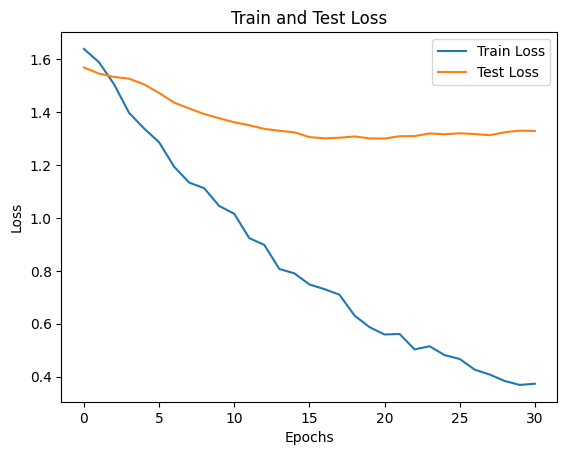

In [23]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

# Преобразование всех столбцов в числовой формат
def convert_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        elif df[col].dtype == 'object':
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                df[col] = pd.factorize(df[col])[0]
    return df

# Выделяем признаки и метки
X = df_combined.drop(columns=['Potential Accident Level Encoded'])
y = df_combined['Potential Accident Level Encoded']

# Преобразование всех данных в числовой формат
X = convert_to_numeric(X)

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование меток классов в диапазон от 0 до num_classes-1
y_train = y_train - 1
y_test = y_test - 1

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader для PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели нейронной сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # уменьшение размера скрытого слоя
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(0.6)  # увеличение dropout
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128  # уменьшение скрытого слоя
num_classes = len(y.unique())

model = MLP(input_size, hidden_size, num_classes)

# Определение функции потерь и оптимизатора с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)  # уменьшение learning rate и увеличение weight decay

# Обучение модели с ранним прекращением
num_epochs = 50
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 10  # Число эпох без улучшений перед остановкой
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Проверка на тестовом наборе
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Раннее прекращение
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Оценка модели
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend((predicted + 1).numpy())  # Сдвиг предсказанных значений на +1
        y_true.extend((y_batch + 1).numpy())    # Сдвиг истинных значений на +1 для правильного сравнения

# Отчет о классификации
report = classification_report(y_true, y_pred)
print("Neural Network Classification Report:")
print(report)

# Проверка на переобучение и недообучение
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

In [ ]:
# Группировка описаний по категориям
grouped = df.groupby('Potential Accident Level')['Description'].apply(lambda x: ' '.join(x)).reset_index()
grouped.to_excel('c:/Users/AADementev/Desktop/Projects/python/MachineLearning/graduation_project_pro/grouped_descriptions.xlsx', index=False)
print(grouped)

In [ ]:
grouped_descriptions = dict(zip(grouped['Potential Accident Level'], grouped['Description']))

In [ ]:
# print(next(iter(grouped_descriptions.items())))

In [ ]:
# Преобразование словаря в список документов
documents = list(grouped_descriptions.values())
categories = list(grouped_descriptions.keys())

In [ ]:
# display(categories[0], documents[0])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# # Загрузка ресурсов NLTK
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [ ]:
# Функция для преобразования части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Функция для лемматизации текста и извлечения только существительных и глаголов
lemmatizer = WordNetLemmatizer()
def lemmatize_and_filter(text):
    words = word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    filtered_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
                      for word, pos in pos_tags if pos.startswith('N') or pos.startswith('V')]
    return ' '.join(filtered_words)

# Применение фильтрации и лемматизации к описаниям
df['Description'] = df['Description'].apply(lemmatize_and_filter)

# Группировка описаний по категориям
grouped = df.groupby('Potential Accident Level')['Description'].apply(lambda x: ' '.join(x)).reset_index()

# Создание признаков из описаний
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(grouped['Description'])
tfidf_feature_names = tfidf.get_feature_names_out()

# Преобразование в DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped['Potential Accident Level'], columns=tfidf_feature_names)

# Функция для получения топ-50 слов по каждой категории
def get_top_n_words(tfidf_df, category, n=50):
    row = tfidf_df.loc[category]
    top_n_words = row.sort_values(ascending=False).head(n)
    return top_n_words

# Вывод топ-50 слов для каждой категории
top_words_by_category = defaultdict(list)
for category in tfidf_df.index:
    top_words = get_top_n_words(tfidf_df, category)
    top_words_by_category[category] = top_words

# Печать топ-50 слов для каждой категории
for category, top_words in top_words_by_category.items():
    print(f"Top 50 words for category '{category}':")
    print(top_words)
    print("\n")

In [ ]:
import matplotlib.pyplot as plt
# Определение количества категорий
num_categories = len(top_words_by_category)

# Создание сетки 3x2
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Проход по категориям и создание графиков
for ax, (category, top_words) in zip(axes.flatten(), top_words_by_category.items()):
    ax.barh(top_words.index, top_words.values, color='skyblue')
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Words')
    ax.set_title(f'Сategory {category}')
    ax.invert_yaxis()  # Инвертируем ось Y для лучшего отображения

# Удаление пустых подграфиков, если категорий меньше 6
for i in range(num_categories, 6):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [ ]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# Загрузка модели SpaCy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Функция для извлечения должностей
def extract_positions(text):
    doc = nlp(text)
    positions = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    return ' '.join(positions)

# Применение функции извлечения должностей к описаниям
df['Description'] = df['Description'].apply(extract_positions)

In [ ]:
# Группировка описаний по категориям
grouped = df.groupby('Potential Accident Level')['Description'].apply(lambda x: ' '.join(x)).reset_index()

# Создание признаков из описаний
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(grouped['Description'])
tfidf_feature_names = tfidf.get_feature_names_out()

# Преобразование в DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped['Potential Accident Level'], columns=tfidf_feature_names)

# Функция для получения топ-50 слов по каждой категории
def get_top_n_words(tfidf_df, category, n=50):
    row = tfidf_df.loc[category]
    top_n_words = row.sort_values(ascending=False).head(n)
    return top_n_words

# Вывод топ-50 слов для каждой категории
top_words_by_category = defaultdict(list)
for category in tfidf_df.index:
    top_words = get_top_n_words(tfidf_df, category)
    top_words_by_category[category] = top_words

# Печать топ-50 слов для каждой категории
for category, top_words in top_words_by_category.items():
    print(f"Top 50 words for category '{category}':")
    print(top_words)
    print("\n")

In [ ]:
from keybert import KeyBERT

kw_model = KeyBERT()

keywords = {}
for category, description in grouped_descriptions.items():
    keywords[category] = kw_model.extract_keywords(description, top_n=20)

print(keywords)

In [ ]:
from rake_nltk import Rake

r = Rake()

keywords = {}
for category, description in grouped_descriptions.items():
    r.extract_keywords_from_text(description)
    keywords[category] = r.get_ranked_phrases()[:10]  # Топ-10 ключевых фраз

print(keywords)

In [ ]:
import spacy

# Загрузка модели SpaCy для английского языка
nlp = spacy.load('en_core_web_sm')

# Пример текста
text = "The technician repaired the equipment. The engineer supervised the project."

# Обработка текста с помощью SpaCy
doc = nlp(text)

# Извлечение существительных
nouns = [token.text for token in doc if token.pos_ == 'NOUN']

print(nouns)  # Вывод: ['technician', 'equipment', 'engineer', 'project']

In [ ]:
import spacy

# Загрузка модели SpaCy для английского языка
nlp = spacy.load('en_core_web_sm')

# Пример текста
text = "The technician repaired the equipment. The engineer supervised the project."

# Обработка текста с помощью SpaCy
doc = nlp(text)

# Извлечение глаголов
verbs = [token.text for token in doc if token.pos_ == 'VERB']

print(verbs)  # Вывод: ['repaired', 'supervised']

In [ ]:
import spacy
from collections import Counter

# Загружаем модель для обработки текста на английском языке
nlp = spacy.load("en_core_web_sm")

# Текст
text = """
At the moment the forklift operator go to manipulate big bag of bioxide in section 70 and just in front of the ladder that lead to the area of ​​manual displacement , he splash spent at the height of his forehead from a fissure in pipe G -069 , subsequently spill to his left eye . The collaborator go to the nearby eyewash for cleaning and immediately to the medical center . Due to the overheat of 2 bar in row 5 of cell 7 a spark be produce , which be project and manages to reach the Chief of guard who be in the corridor , produce a first degree burn in the neck . An auxiliary wheel of the cathode crane G2133 be change in area 75 , when when a bearing be heat and hit with a hammer and chisel at one end of the bearing track , a detachment of a bearing piece occur , impact it in the thigh of the right leg produce a cut . The ambulance be call and you be transfer to the clinic . At 14:16 , the operator Samuel be about to open the container for it subsequent load with silver concentrate , and open the first gate . Afterwards , he try to open the second door and it be when product of the opening of the latter , the first one open and impact with the handle the safety lens and generates the injury in the left cheekbone of the face of the operator . By loosening the A30-29 truck 's steer cylinder bolt use power cable and socket , with the force exert in favor of the equipment , the bolt suddenly retire and the employee hit his hand against the structure of the equipment , cause injury . An operator of the G-2142 deslaminadora in section 75 be unlock a sheet of zinc stuck so that it can enter the slide of the stack table , for this require the support of Mr. Mollares and this help to hold the sheet to place it in the entry chute to the slide . At the moment of release the blade , it tilt and brush Mr. Mollares 's left leg . The collaborator go to the nearby eyewash for cleaning and immediately to the medical center . The operator be willing to manually displace the zinc sheet adhere to the aluminum cathode . At the moment when the blade be detach , the blade be release from the cathode , bending and grazing the collaborator 's right hand , produce 2 small cut at the knuckle of the finger , the worker make use of his glove . leather . The worker be transfer to the medical unit for first aid . When the plant operator be semi-kneeling when lift the lid or gate ( 15 kg ) of the distributor box of the secondary mill No . 4 and No . 5 , his right knee slip due to the presence of debris spill on the platform or floor ( Grating ) - which give him an extra effort in his left leg , generate a muscle contracture . At level -1095 - Access 6 A2 - at time when the engineer trainee planamieto enter to verify the amount of split set place by the Scissor 184 in the support - hold his notebook and pen in his left hand - while inspect the roof of the work , he lose the balance when step on a rock hold the right hand on a rock on the floor cause the injury . The worker at the time of the accident wore glove but do not use them because it make it difficult to take note . The employee be clearing the pipe when he tapped his right thumb against the flange cause little trauma . When instal the ripper pin of the tractor D6T-N1 , the ripper support arm slide by press the second and third finger of the right hand against the base of the ripper cause the injury described . The employee report that when he low the cloth in the purification , he arrange the cart so that it would not grab the pipe , press his left hand between the cloth and the cart . At the end of the load of explosive on the work front , the master loader enters to verify the moor of the blasting accessory , when retire from the top ( 1.5 m ) , he hears the sound of fragment of rock roll through the support mesh , directs it gaze towards the crown in a vertical form , at which point a small fragment of rock ( 2x3x2cm ; 36gr ) pa through the opening of the mesh . sustain impact on the forehead . At the time of the event the collaborator use his helmet and safety lens and the front be with support to the top and sacrifice mesh . The opening of the support mesh be 3 `` x 3 `` . The employee , when perform the adjustment / tighten operation of the cutter blade with which he work , be neglect , the key to slip , cause the blade of the equipment to hit him , cause a blunt cut on his right forearm . When carry out the activity of cut electrowelded mesh on the work front , the assistant position his foot on one end of the mesh leave the other end free , at the moment that the assistant bend down to make the cut with the shear , the end free of the mesh return by inertia hit the partner above his safety lens . When access the Santa do Novo area , in order to open the chop , General be move ahead of the team in order to open access for Manetometer , when he come across an area with a steep slope and gravel presence . In a certain place of access the employee slip , come with this to become unbalanced . At that moment the machete that be in his left hand come to slip the right leg above the knee , cause a cut 3cm . In the workshop level -970 in Box # 1 , while TWO the mechanic manipulate a steel plate - 60cm x40cm x 2.5cm ; 50 Kg - to place it in the gutter of the workshop and be able to remove the Scaler # 142 , the plate slide and restricts the right ring finger between the gable and the plate cause the injury . The collaborator use glove at the time of the accident After parking a van next to a cluster of wooden sleeper and board , the driver , on descend , step on a board in which an iron nail protrude 11/2 `` long , which he do not identify a the board be submerge in a puddle of water . This accident cause a minor wound on the sole of the left foot . At the time of the accident the worker be wear safety boot . In bypass 100 of level 1970 when the worker of the company Incimet Raul ( operator of Bolter bolting team ) and Rolando ( assistant ) retire after instal the support with helical bolt , the pink team with a mesh overhang the gable , so the teacher tell his assistant to cut the mesh and the instant the assistant finish cut the mesh , it suddenly rise hit his face cause the injury described . In general store , while two store attendant remove the compartment a rubber mesh for material classification - 1.8 m.x1.2 m.x0.02 m . ; 60 kg of weight - when lift approx . 40 cm to position it against the edge of another mesh place on the floor on a litter , this slightly imprisons the index finger of the right hand of one of the assistant cause a minor cut wound . At the time of the accident the injured worker use leather glove . the workshop at the end of the weld work in the small bolter equipment , the welder proceeds to clean the inside of a metal stool , impregnate with thinner ( flammable liquid ) and with the help of a hammer and screwdriver proceeds to remove the oxide , when hit The screwdriver with the hammer produce a flash in the internal base of the stool , which produce a slight burn in the right hand of the welder . - At the time of the accident , the welder only u a glove on the left hand .. The injured woman perform cleaning and when cleaning the sink of the collection room pierce the finger with a fragment of glass . The injured worker begin the work of present the support mesh cloth on the floor , make an initial cut in the mesh of a section of 0.3 m x 2.0 m for the poncho , originate in the remain mesh wick ( tip with prong ) protrude . When try to make a second mesh cut , it be position at the edge of the remain mesh with wick to prevent them from curl , at which point it try take your shear and remove the right foot of the mesh cause the mesh to roll up and embed a wick ( tip with pole ) through the left boot cause the injury . At the time of the accident the worker be wear safety boot . During the die cut of the feeder ( PEAD geomembrane blanket weld seam ) to store the extruder , the stylet blade come in the direction of it left forearm , result in blunt short injury . On Sunday , 15 , the collaborator go to the medical center say that he have an accident 3 day ago when he perform internal maintenance work on the heat exchanger , define a a confine space and at risk of burning with acid . When leave the confine space , the employee remove the protective glove without have pa through the emergency shower ; At that moment , skin contact occurs with sulfate , generate the lesion . When an employee of MILPO Lima visit the facility , when he be at level 2900 , wait for the personnel cage to go up to level 4070 , drop of water fall from the ceiling from a height of 2.20 meter approximately , product of a slight filtration in the crown ( sustain with shotcrete ) , a drop enters the right eye cause discomfort in the right eye . According to the employee , at the time of the accident the lens have be remove to clean them , this happen after the visit to the interior of the mine . In circumstance that the collaborator perform the cleaning of the ditch 3570 , 0.50 cm deep , remove the pipe of 2 `` HDPE material with an estimate weight of 30 Kg . Together with two collaborator , when push the tube to drain the dune , the collaborator be hit on the low right side lip produce a slight blow to the lip . At the time of the event , the collaborator have a safety helmet , glass and glove . During the field trip , on LT 01 of the Lajes target , Junior da Costa official step on a wooden stump that be on the ground , approximately 5 cm , which pierce his boot wound the sole of the right foot . At the time of the accident , the employee be use all the PPE require for the activity and have his hand free . The employee be take to the hospital , where he go through medical care , and be release to return to his activity the next day of work . When handle a lever to move the sludge , the employee move it by make a pendulum movement and strike his chin . At level 3490 gallery 447 , after perform the manual unlock on load , the worker prepares to cut the sacrificial mesh that be expose after the previous turn shot , place himself under it with a 12-inch shear , when cut the fifth suddenly strain wire of the mesh return to his face casionándole the injury described . During the activity the worker use his safety glass . In circumstance in which the adjutant of the scissor bolter come down by the team 's ladder - last step - it slide from an approximate height of 0.9 m. and fall sit on the floor . At the time of the accident , the person involve in the use of the helmet ; there be no rock or material in the crash site . At level 2900 at the entrance of the locomotive workshop , the welder proceeds to inspect the mining car and identifies that the No . 24 car have bearing problem , informs his partner about this find and decides to enter the car to the workshop , so it operates the swing arm type mona of 15 KG . of weight to move the direction of the railway towards the central OP , be at this moment that push the rocker with the weight of his body until his right hand come in contact with the rock produce the injury described . At the time of the accident the worker be wear the safety glove of pad . when handle a sample in the laboratory , the sleeve of the employee 's coat have contact with nitric acid , absorb a small amount that come to reach the left forearm , cause a 1st degree burn . At the Eusébio bridge , there be a sudden brake in which several car have to brake quickly . The collaborator 's car fail to stop in time and collide with the rear of the car ahead . They be about 40km / hour . During torch cut activity of the new evaporator treatment fix , there be a rupture of the hose near the torch pen , cause the injury . employee report that upon initiate 615RLC front load activity , during the elevation of the aerial work platform , a rock fragment from the roof of the gallery be drop , reach it face , cause the lesion . When remove the cap from the wear plate of the Warman LX-BB-01 pump , the left hand of the employee who be with the glove slip come to have contact with the cut part of the board . The servant would remove the dish from the bowl of the sink and when pick up a set of plate , there be one of them with the broken / broken edge , cause injury to his 3rd chiropactyl from his right hand . Once the topographic survey in the Stp . 440 ( East zone ) , the victim and his co-worker , decide to continue with their work in the Stp . 440 ( West ) , for this the injured person walk behind his co-worker ( 10 to 15 meter ) , when arrive at the load zone ( intersection Rpa 175 and St 440 ) the injured person asks the sccop operator to stop to pa , once the equipment be stop , the victim pa behind his partner stuck to the gable , try to avoid the accumulation of water , when he take the third step into the puddle , the injured person step on the false and fall to the floor , cause the injury . The employee report that after carry out activity in the area of ​​the Expedition be to remove the overall and have contact with material that contaminate the sleeve , which cause 1st degree burn in the right forearm . At 22:50 hour in row 12 when the cell suction partner remove the suction hose , untimely splash of electrolyte solution in the left eye . Immediately he be refer to the medical service . During the execution of the area cleaning activity use a hoe , the employee hit against a fix metal structure in the area , come to reach the abdomen on the left . Collaborator be cleaning the sink of the Copper repulping area , at the moment of fill the truck with the shovel , he project sludge towards the lens ; soil them and obstruct vision . The worker indicates that when remove the lens to clean them , some mud particle enter the left eye cause discomfort . It be refer to the medical center for the correspond attention . the check list of the area of ​​the survey the operator slip in the foliage of the leucenas and fell . By participate in the general DDS held in the outside area of ​​the central locker room the employee be bitten by a bee . The employee report that when perform the maintenance activity of pump on the tunnel of the TC-020 , a he be pull out the rotor , struck the piece with the mallet that slip from his hand . Reaching the low part of your left leg , cause the injury . employee be remove the strap from a chemical container a it project toward him reach his low lip and anterior chest , the strap be contaminate with caustic soda and cause a 1st degree burn . On September 17 , 2016 at approximately 8:35 pm , during the preventive maintenance of the G2142 debark machine , the bearing assembly be make on the anode cleaning roller ; When fitting the bearing in it final position , the staff use a chisel and a 4-pound rope to position the bearing . The worker place his left hand near the head of the chisel and warp , in these circumstance a splinter be embed in the proximal part of the thumb of the left hand , immediately the collaborator communicates to the supervisor and be evacuate to the Medical for review . The employee be perform maintenance of the blower , when the residual water projection occur on his face . In an attempt to remove PPE , the injured person have have contact with contaminate glove with the right eye cause irritation . The lubricate technician Alfredo make the oil fill to the reducer D-100 , in which , he notice an oil leak ( tear ) between the connection of the hose and the reducer , correct the leak . Once the work be finish , he go to the lubricant workshop where he remove the glove and observes that both hand be affected by contact with the hot surface and go to the medical center where he be treat . At 14 : 55h on 27 September , a worker from Confipetrol carry out industrial cleaning of the outside of the acid reduction tank D2055 , to check the progress of the helmet mask ; moment that hose pipe be release that be secure with pressure clamp ( for water and air ) , impact lip Being 05:30 be . Approximately Marco and Isidro TORRES they be perform the pipe standardization of the CX 771 / CX-983 Nv . 1940 ; in moment that Marco lift the air pipe over the spike , this seat and the pipe impact on the worker 's safety guard . Being 5:15 a.m. in the N. in the NV 1710 CX 018 , the mixkret operator be wash the mixkret 116 with a hose with water under pressure , it be necessary to change the location ; from the right side to the left and He proceeds to pull the hose then slip and feel that the left foot bend . During the withdrawal of cathode sample the employee come to press the finger with the tool that cut the sample . At the office of Incimmet , in circumstance that an environment be be set up to place cleaning material , a wooden strip be place between the staircase structure and the container , this strip be not cut to size , so the accident victim He coordinate with his partner to put it under pressure use a hammer while hold with his right hand the frame , this pressure place strip push to that side of the container create an opening between the corrugate iron and the wall , at that time , continue to hit the ribbon , This fall cause the wall of the container to return to it initial position , press the tip of the little finger of the right hand against the corrugate iron cause the accident . Employee assist in the support of the gate , while the other the tie of the canvas in the frame , and by press the rope so that the canvas stretch , the metal structure move , come out of the wooden support , fall and strike against the employee 's face , cause a cut in the right superciliary . When ignite the furnace 07 of the battery I , there be reflux of hot gas , reach the face of the employee . Being the 01:30 hr , After the cathode go through the pre estriping , the sheet be detach and bend to the cathode of it position , the operator with the assistant lift the cathode by the head to position it in the tranfer at that moment the detach sheet exerts pressure on the cathode hit the palm of the left hand of the operator with the head and the transfe , activity be paralyze and the collaborator be refer to the medical post by the head of the guard . Being approx . 3:10 a.m. Mr. Denis make the mesh place in a ventilation plug up a ladder , while try to do a wire tie , suddenly have an imbalance due to the manipulation of tool fall from the third step , propiciándose a blow in the right knee and a wound of the wrist of the right hand . Later he be evacuate to the post where he receive first aid . The employee report that upon initiate 615 RLC front load activity while perform the emulsion preparation for use there be a displacement of a small rock fragment from the ceiling reach his left forearm After the welder complete the weld work to reinforce the form in the deepen , he walk towards the distant truck at about 40 mt , at which point the welder step on a fragment of rock of 5 cm x 10cm x 5cm approx . which generates that the foot flex and generates the injury in the worker . At 18:40 hour , in moment when Mr. Claudio tipper operator readjust the nut of the rear tire on the right side of his vehicle , use a wheel wrench and a tube a an extension to generate great force of torque ; which be Mr. Wilber held him in his back ; suffers a contusion in the palm of the right hand a the extension to his partner slip from his hand . When enter the caustic soda containment basin to place the hose to make the suction , at this stage there be steam formation , strike the employee in the right and left calf . During the activity of revegetation of the slope of the pit pit II , the employee hit the sledgehammer on the rod for installation of the lifeline , it hit his right leg , cause a slight excoriation . Employee report that he perform an activity in the area of ​​the Ustulación , under the coordination of Maintenance when he be hit by dust from the ustulado , cause irritation in the eye region . On December 13 , the accessory couple ( gun - hose ) of the high pressure pump ( BAP ) be make to clean the demister of the cool tower G2172 . carry out the complete couple , they turn on the BAP to start with the start test , at that moment the hose come off the gun and hit Mr. Emerson who be hold the gun . The maid while walk in the electrolysis area , stumble and fell next to the bathroom in room B . Employee report that he perform solder activity when he be hit in the eye region by dust that be found in the thermal insulation , cause irritation . Mr. Marcelo withdrew foam from the ajax oven , use the metal spoon to empty it into the foam waste container . At that moment splash of slag residue , impact the face and generate a surface burn . The worker be wear a face mask . At 13:40 hour , Mr. Jose perform the erase of the earthenware of section 30 , when turn on the machine of alizado ( iron ) of concrete , this tour abruptly imprison his left hand between the command of the equipment and the metal structure , cause an atriction in the back of the left hand . During the reduction activity in the tube , the employee attach the tube to the walrus , and when he hit the tube with the hammer , he untied the walrus by reach his finger . On 01/02/2017 , at 10:15 a.m. , when perform the Soil activity , the collaborator Alex use a pickaxe to assist in the opening of the collection hole . As he struck the ferranta on the ground , he have a fragment of rock project on his forehead cause a small cut . The activity be paralyze for a few moment and it be not necessary to go to the doctor , the employee continued the activity normally . On 05/02/2017 , at 10:40 p.m. , when perform geological mapping activity , the geologist Manoel da Silva accompany by the geologist Luciano do Santos and Dayme have to make the cross to the other side of a fence barbed wire , know in the region a a goat . It be a fence that from the base up to about 60cm in height be make by rod interlaced horizontally and upwards make with little barbed wire barbed , around 15 to 20cm . I jumped on the fence , and still on the fence I manage to `` sweep `` the vegetation with the left foot but even so while support the foot on the ground a stump of approximately 10cm x 1cm come to break the sole of the boot and cause the perforation in the left foot at the height of the finger . The collaborator complete the misalignment of the nut on the left side of the chute scraper of strip No . 9-2 , when he get up he turn and hit the head guard with the rail , hit the lens generate the injury . During the preparation for the office cleaning activity , the employee make use of the stair rail , it have contact with the clamp use to lock the signal board . By average 8:23 be at the office of Ajani , Liliana prepares to store folder in the warehouse , to go to the place it come out of the iglu , when go down the two step it do so diagonally so it sits the left foot on the edge of the second step cause the foot to bend Left inward , it stabilizes quickly avoid fall to the ground . The industrial cleaning worker Cristian be perform the cleaning activity of the gutter , strike with a wall of the same , to remove the solid solution that be form . In that At the moment the operator 's hand slide and impact on the edge of the gutter , cause a blow on the little finger of the left hand . Employee to perform painting of the floor of the fuel tank area , he need cleaning , and by pour water-thinner on the floor , the bucket slip out of his hand and the mixture project onto his left shoulder and low lip , cause redness and burning . At the end of the concrete activity , the employee turn off the concrete , and when roll the handle to make the return of the equipment warehouse the same bumped the tip of the mangote in the inferior lip cause hematoma . During the mark of the management point , the supervision and the breeder enter the work to carry out the ventilation inspection , for which the survey work stop to turn on the fan and proceed with the air flow measurement . When the fan be turn on due to pressure , it break the fasten point of the toe and the sleeve fall to the floor generate a chicoteo from gable to gable , product of the chicoteo a fragment of the aggregate of the shocrete be project on the face of the injured person produce the injury . Approx . 10:00 pm . Mr. Victor at the time he make a visual inspection of scaffold , suffer a slight blow to the level of the right ear with the metallic extension of the chute of the conveyor chain . The employee report that he perform his routine activity in the Foundry area when it be necessary to fit the last ZAMAC ingot of one of the package . At this point , the ingot slip and hit the back of his right foot , cause pain . The safety footwear worn by the employee have a steel toe and a metatarsal protector . The employee report that he perform his routine activity in the area of ​​Electrolysis when , when try to position one of the cathode sheet on the easel , it hit his sleeve and cause a cut in the same and superficially in the left hand . Employee be engage in adjust metallic shape use a tether , and strike the shape , the tether cable hit the lifeline , project it hand into the metal structure of the shape , cause a superficial injury to the ring finger of the right hand . At 04:00 h on 05/19/17 , the mechanic on duty of section 40 Antonio be observe in the activity of withdrawal check out of POM D071 , at this moment he be impact by a pulp of the line of discharge stuck , cause irritation in the right part of the neck and ear . The mechanic be refer to the medical center for evaluation . Upon enter the building , the maid slip and fell just behind the automatic door , in front of the entry mat . The floor be wet and slippery . In circumstance that the worker prepared food in the electric pot , by not ensure the lid fall on his head cause the injury described . In circumstance where the worker and two partner be place a killer bomb in the basket of a Manitou team , the bomb hit the index finger of the right hand against the basket . Approx . 18:40 hour , Mr. Luis maintenance team of mobile equipment , adjust a bolt of the front loader J005A , at which time his face be impact by the key use for this activity , produce a slight cut in the surface of the face . He be transfer to the medical service , attend and register . On the surface , Comedor the worker of the company C & C make the cut of lemon at that time imprison the knife generate a movement and impact on the first finger of the left hand cause a slight cut . Employee report that by remove the zinc sheet from the cathode to take it to the easel , it slip from his hand , fell and hit his left foot . The collaborator move from the infrastructure office ( Julio to the toilet , when the pin of the right shoe be hooked on the bra of the left shoe cause not to take the step and fall untimely , cause injury described . During the environmental monitoring activity in the area , the employee be surprised by a swarm swarm of weevil . During the exit of the place , endure suffer two sting , be one in the face and the other in the middle finger of the left hand . The Employee perform the activity of strip cathode , when pull the cathode sheet his hand hit the side of another cathode , cause a blunt cut on his 2nd finger of the left hand . At 10:00 a.m. , when the assistant clean the floor of module `` E `` in the central camp , she slip back and immediately grabbed the laundry table to avoid fall to the floor ; suffer the described injury .
"""

# Функция для извлечения должностей
def extract_positions(text):
    positions = set()
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG"]:
            positions.add(ent.text)
    return list(positions)

# Функция для извлечения оборудования и инструментов
def extract_equipment(text):
    equipment = set()
    doc = nlp(text)
    for token in doc:
        if token.pos_ == "NOUN":
            equipment.add(token.text)
    return list(equipment)

# Функция для извлечения действий
def extract_actions(text):
    actions = set()
    doc = nlp(text)
    for token in doc:
        if token.pos_ == "VERB":
            actions.add(token.lemma_)
    return list(actions)

# Извлечение данных
positions = extract_positions(text)
equipment = extract_equipment(text)
actions = extract_actions(text)

# Вывод результатов
print("Должности:")
print(positions)
print("\nОборудование и инструменты:")
print(equipment)
print("\nДействия:")
print(actions)